# Proyecto recorridos de un vendedor multiples dias. Instancias aleatorias.

Se importan todas las librerias a ser usadas por el modelo

In [1]:
import numpy as np
import pandas as pd
import setup
from docplex.mp.model import Model
from docplex.mp.conflict_refiner import ConflictRefiner
import time
import matplotlib.pyplot as plt

Se reciben los parametros generales del modelo

In [2]:
tiempoEnLocal = 30 #Parametro que nos marca cuantos minutos se queda un vendedor en un local

maxTiempo = 360 # Es la maxima cantidad de minutos que puede tener el dia de un vendedor EN TOTAL,
                # incluye traslados desde la oficina al primer local al principo del dia, 
                # incluye tiempos en cada local, 
                # incluye todos los traslados de local a otro local,
                # e incluye el ultimo tramo desde el ultimo local hasta la oficina.
                
locs = 18 # Este parametro es porque vamos a generar esta cantidad de locales aleatorios en un mapa. (sin incluir oficina)

esparcidadLocales = 100 # este parametro toca cuan distantes estan los locales entre si, al generarlos se generaran
                        # en una posicion aleatoria entre 0 y este numero, en ambas coordenadas del mapa.
    
ruidoDeMapa = 0.0 #este parametro nos dice cuan grave puede llegar a ser el trafico para hacer el grafo de distancias asimetrico
                # es decir, no vale que la distancia de x a y sea igual a la distancia de y a x. 

Se define la funcion que nos dara la matriz de distancias y las distancias desde y hasta la ofi de cada local. teniendo un poco de ruido en la generacion de distancias

In [3]:
def generarMatrizDistancias(posicionesX, posicionesY, posicionOfi, cantRuido):
    long = len(posicionesX)
    distancias = np.zeros([long,long])
    distDesdeOfi = np.zeros(long)
    distHaciaOfi = np.zeros(long)
    for i in range(0, long):
        ruido = np.random.rand(1)[0]*cantRuido
        distDesdeOfi[i] = (1+ruido)* (((posicionesX[i]-posicionOfi[0])**2 + (posicionesY[i]-posicionOfi[1])**2)**0.5)
        ruido = np.random.rand(1)[0]*cantRuido
        distHaciaOfi[i] = (1+ruido)* (((posicionesX[i]-posicionOfi[0])**2 + (posicionesY[i]-posicionOfi[1])**2)**0.5)
        for j in range(0, long):
            ruido = np.random.rand(1)[0]*cantRuido
            distancias[i][j] = (1+ruido)* (((posicionesX[i]-posicionesX[j])**2 + (posicionesY[i]-posicionesY[j])**2)**0.5)
    return distancias, distDesdeOfi, distHaciaOfi

Se generan las listas de indices donde se moveran las variables y se genera la matriz y las listas de distancias

In [4]:
locales = list(range(0,locs))
dias = list(range(0, 9)) # Podemos definir que tenga una menor cantidad de dias disponibles, 
                            # para garantizar satisfabilidad pondria la misma cantidad de locs. 
                            # Pero para ser mas exigente solo la mitad
nombresLocales = list(map(str, locales))
posicionesX = np.random.rand(locs)*esparcidadLocales
posicionesY = np.random.rand(locs)*esparcidadLocales
posicionOfi = [esparcidadLocales/2, esparcidadLocales/2] #Se asume que la ofi esta en el medio del mapa

distancias , distDesdeOfi, distHaciaOfi = generarMatrizDistancias(posicionesX, posicionesY, posicionOfi, ruidoDeMapa)


Graficamos las ubicaciones generadas

Text(0, 0.5, 'Posicion eje y')

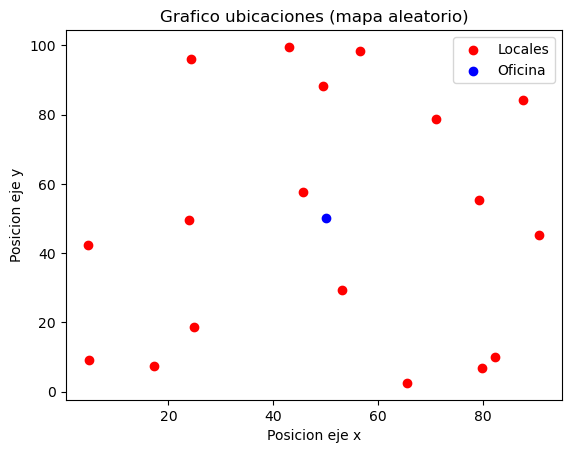

In [5]:
plt.scatter(posicionesX,posicionesY, c="red")
plt.scatter(posicionOfi[0], posicionOfi[1], c="blue")
plt.legend(["Locales","Oficina"])
plt.title("Grafico ubicaciones (mapa aleatorio)")
plt.xlabel("Posicion eje x")
plt.ylabel("Posicion eje y")

Definimod modelo y declaramos las variables que vamos a usar

In [6]:
mdl = Model(name="modeladoTSPdays")

In [7]:
visito = mdl.binary_var_matrix(locales, dias, name= "v", key_format="visito")
esRaiz = mdl.binary_var_matrix(locales, dias, name= "esR", key_format="esRaiz")
esFinal = mdl.binary_var_matrix(locales, dias, name= "esF", key_format="esFinal")
tiempoUsado = mdl.continuous_var_list(dias, name= "tiUs", key_format="tiempoUsado")
usaDia = mdl.binary_var_list(dias, name= "usaDia", key_format="usaDia")
tramo = mdl.binary_var_cube(locales, locales, dias, name= "tramo", key_format="tramo")
orden = mdl.continuous_var_matrix(locales, dias, name= "orden", key_format="orden")
M = 100000

No vale que en un recorrido haya subciclos, entonces tiene que haber un orden estricto en cuanto a cuando visito cada local.

In [8]:
for d in dias:
    for l1 in locales:
        for l2 in locales:
            mdl.add_constraint_(orden[l1,d] + tramo[l1,l2,d]<=orden[l2,d] + 1000*(1-tramo[l1,l2,d]))


Si es que visito un nodo un determinado dia, entonces:

La cantidad de aristas hacia afuera de un nodo es 1 o es el final del recorrido y de ahi va directo a la oficina.
Analogamente la cantidad de aristas hacia adentro de un nodo es 1 o es el principio del recorrido (raiz).

In [9]:
for d in dias:
    for l1 in locales:
        sumaAdy = 0
        sumaExc = 0
        for l2 in locales:
            sumaAdy = sumaAdy + tramo[l2, l1, d]
            sumaExc = sumaExc + tramo[l1, l2, d]
        mdl.add_constraint_(visito[l1, d] == sumaAdy + esRaiz[l1,d])
        mdl.add_constraint_(visito[l1, d] == sumaExc + esFinal[l1,d])

Tenes que visitar a todos los locales exactamente 1 vez a lo largo de todos los dias, y no podes viajar desde un nodo a ese mismo nodo

In [10]:
for l1 in locales:
    vis = 0
    for d in dias:
        vis = vis + visito[l1,d]
        mdl.add_constraint_(tramo[l1,l1,d]==0)
    mdl.add_constraint_(vis==1)

Solamente puedo hacer una arista en un solo dia, y no en muchos dias.

In [11]:
for l1 in locales:
    for l2 in locales:
        cantTramos = 0
        for d in dias:
            cantTramos = cantTramos + tramo[l1,l2,d]
        mdl.add_constraint_(cantTramos<=1)

Si use una arista en un sentido, no la puedo usar en el sentido opuesto, ademas si use un tramo de nodo A a nodo B entonces ese dia visite ambos nodos A y B.

In [12]:
for l1 in locales:
    for l2 in locales:
        for d in dias:
            mdl.add_constraint_(tramo[l1,l2,d] + tramo[l2,l1,d] <=1)
            mdl.add_constraint_(visito[l1,d] + visito[l2,d] >= 2*(tramo[l1,l2,d] + tramo[l2,l1,d]))


Si un dia lo utilizo para visitar locales (puede ser que los dias del final no sean necesarios) entonces aquellos dias que haya recorrido debo tener exactamente un punto de partida raiz y un solo final.

In [13]:
for d in dias:
    esr = 0
    esf = 0
    for l1 in locales:
        esr = esr + esRaiz[l1,d]
        esf = esf + esFinal[l1,d]
    mdl.add_constraint_(usaDia[d] == esr)
    mdl.add_constraint_(usaDia[d] == esf)
    

Si viaje e hice algun traslado entonces use el dia, si no hice ningun viaje entonces no use el dia.

Es importante que cada dia que haya usado no supere mi limite de tiempo diario.

Busco minimizar principalmente la cantidad de dias que uso y secundariamente la cantidad de tiempo en esos dias.

In [14]:

sumaDias = 0
sumaTiempos = 0
for d in dias:
    mdl.add_constraint_(M*usaDia[d] >= tiempoUsado[d])
    mdl.add_constraint_(usaDia[d] <= tiempoUsado[d])
    mdl.add_constraint_(tiempoUsado[d]<=maxTiempo)
    sumaDias = sumaDias + usaDia[d]
    sumaTiempos = sumaTiempos + tiempoUsado[d]
mdl.minimize(sumaDias*(100000) +  sumaTiempos)

El tiempo usado es la cantidad de locales que visitaste, y todos los tramos.

In [15]:
for d in dias:
    sumaTus = 0
    
    for l1 in locales:
        for l2 in locales:
            sumaTus = sumaTus + tramo[l1,l2,d]*distancias[l1][l2]
    for l1 in locales:
        sumaTus = sumaTus + visito[l1,d]*tiempoEnLocal
        sumaTus = sumaTus + esRaiz[l1,d]*distDesdeOfi[l1]
        sumaTus = sumaTus + esFinal[l1,d]*distHaciaOfi[l1]
    mdl.add_constraint_(tiempoUsado[d] == sumaTus)

            

Ordena los dias, no uses el 3 si no usaste el 1 y 2


In [16]:
for d in dias:
    if(d!=0):
        mdl.add_constraint_(usaDia[d-1] >= usaDia[d])

Solver y su tiempo de corrida una vez definido

In [17]:
mdl.set_time_limit(200) # segundos maximo
msol = mdl.solve()

Respuesta en texto

In [18]:

print("El vendedor recorre todos sus clientes en "+str(int(msol.get_value(sumaDias)))+" dias")
print()
for d in range(0,int(msol.get_value(sumaDias))):
    print()
    print("En el dia " + str(d+1) + ": ")
    localinicio = -1
    localfinal = -1
    cantLoc = 0
    for l1 in locales:
        if(msol.get_value(esFinal[l1,d])):
            localfinal = l1
        if(msol.get_value(esRaiz[l1,d])):
            localinicio = l1
        if(msol.get_value(visito[l1,d])>0.5):
            cantLoc = cantLoc + 1
            
            
    print("visito " + str(cantLoc) + " locales en un tiempo de " + str(round(msol.get_value(tiempoUsado[d]),2))+ " minutos")
    print("Empezo por "+ nombresLocales[localinicio] )
    localActual = localinicio
    listaLocales = [localActual]
    while(localActual!=localfinal):
        for l2 in locales:
            if(msol.get_value(tramo[localActual,l2,d])>0.5):
                print("Luego a "+ nombresLocales[l2] )
                localActual = l2
                listaLocales.append(l2)
                l2 = 0

    

    

El vendedor recorre todos sus clientes en 4 dias


En el dia 1: 
visito 6 locales en un tiempo de 330.75 minutos
Empezo por 16
Luego a 8
Luego a 15
Luego a 14
Luego a 17
Luego a 0

En el dia 2: 
visito 5 locales en un tiempo de 296.11 minutos
Empezo por 2
Luego a 7
Luego a 3
Luego a 5
Luego a 6

En el dia 3: 
visito 2 locales en un tiempo de 164.0 minutos
Empezo por 10
Luego a 9

En el dia 4: 
visito 5 locales en un tiempo de 286.02 minutos
Empezo por 1
Luego a 11
Luego a 13
Luego a 12
Luego a 4


In [19]:
def graficarFlecha(origenX, origenY, destinoX, destinoY, col):
    plt.arrow(origenX, origenY, destinoX-origenX, destinoY-origenY, length_includes_head=True, head_width=1, color=col)


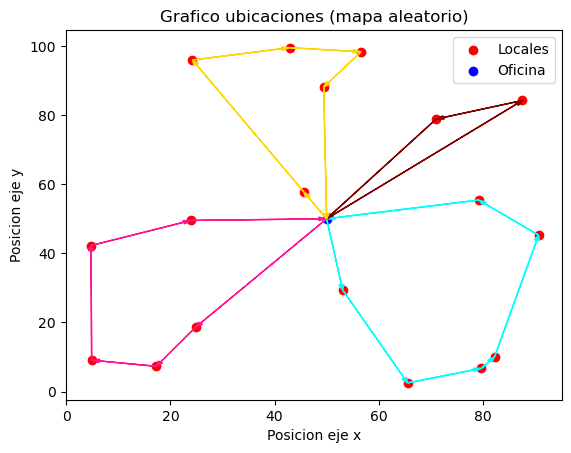

In [20]:
plt.scatter(posicionesX,posicionesY, c="red")
plt.scatter(posicionOfi[0], posicionOfi[1], c="blue")
plt.legend(["Locales","Oficina"])
plt.title("Grafico ubicaciones (mapa aleatorio)")
plt.xlabel("Posicion eje x")
plt.ylabel("Posicion eje y")

cols = ["cyan","deeppink","maroon", "gold","darkgreen","olivedrab","orange","lime","blue", "purple", "black", "yellow","gray"]
for d in range(0,int(msol.get_value(sumaDias))):
    localinicio = -1
    localfinal = -1
    cantLoc = 0
    for l1 in locales:
        if(msol.get_value(esFinal[l1,d])):
            localfinal = l1
        if(msol.get_value(esRaiz[l1,d])):
            localinicio = l1
        if(msol.get_value(visito[l1,d])>0.5):
            cantLoc = cantLoc + 1
            
    graficarFlecha(posicionOfi[0], posicionOfi[1], posicionesX[localinicio], posicionesY[localinicio], cols[d])
    graficarFlecha(posicionesX[localfinal], posicionesY[localfinal],posicionOfi[0], posicionOfi[1], cols[d])

    localActual = localinicio
    listaLocales = [localActual]
    while(localActual!=localfinal):
        for l2 in locales:
            if(msol.get_value(tramo[localActual,l2,d])>0.5):
                #print("Luego a "+ nombresLocales[l2] )
                graficarFlecha( posicionesX[localActual], posicionesY[localActual], posicionesX[l2], posicionesY[l2], cols[d])
                localActual = l2
                listaLocales.append(l2)
                l2 = 0
    
